Data Wrangling
----

# Outline

# Setup

In [1]:
import pandas as pd
import requests
import numpy as np
from datetime import datetime
from os import getcwd
import json
import gzip
print("Working directory: ", getcwd())

Working directory:  c:\Users\marks\coding\QualAbstracts\notebooks


# Filtering for Social Science and Humanities Articles

## Links to APIs
- Finding registration authority: https://www.doi.org/the-identifier/resources/factsheets/doi-resolution-documentation#4-which-ra
    - Note, vast majority of academic articles are on crossref
- Crossref lookup by doi: https://api.crossref.org/swagger-ui/index.html#/Works/get_works__doi_
    - Note preference for including email
    - Or download 185GB as torrent: https://www.crossref.org/blog/2023-public-data-file-now-available-with-new-and-improved-retrieval-options/
- DataCite: https://support.datacite.org/docs/api-get-doi 

## CORE metadata

In [2]:
articles_md = pd.read_csv('../data/all_articles_notext.csv.gz')
print(articles_md.info())
articles_md.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1650037 entries, 0 to 1650036
Data columns (total 5 columns):
 #   Column    Non-Null Count    Dtype 
---  ------    --------------    ----- 
 0   doi       1650036 non-null  object
 1   title     1650033 non-null  object
 2   abstract  1649014 non-null  object
 3   issn      1548098 non-null  object
 4   subjects  686568 non-null   object
dtypes: object(5)
memory usage: 62.9+ MB
None


,doi,title,abstract,issn,subjects
0,10.1111/1467-8330.00227,Institutionalising future geographies of finan...,This paper provides a critical overview of rec...,'0066-4812',NaN
1,10.1163/13822373-90002428,Landscaping Hispaniola Moreau de Saint-Méry's ...,This article focuses on Médéric Louis Élie Mor...,"'issn:1382-2373', '1382-2373'",NaN
2,10.3354/meps09193,Modelling the effect of vertical mixing on bot...,Reliable estimates of in situ phytoplankton gr...,"'1616-1599', 'issn:0171-8630', 'issn:1616-1599...",NaN
3,10.1177/1350508408095817,The Body Dances: Carnival Dance and Organization,Building on the work of Pierre Bourdieu and Ma...,'1350-5084',sociology
4,10.1016/s0022-4049(02)00180-9,Arithmeticity of Orbifold Generalised Triangle...,Maclachlan and Martin have proved that only fi...,'0022-4049',NaN


In [3]:
# records without DOIs are useless
articles_md.dropna(subset=['doi'], inplace=True)
# remove duplicated DOIs
articles_md.drop_duplicates(subset=['doi'], inplace=True)
articles_md.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1639120 entries, 0 to 1650035
Data columns (total 5 columns):
 #   Column    Non-Null Count    Dtype 
---  ------    --------------    ----- 
 0   doi       1639120 non-null  object
 1   title     1639116 non-null  object
 2   abstract  1638100 non-null  object
 3   issn      1537955 non-null  object
 4   subjects  683181 non-null   object
dtypes: object(5)
memory usage: 75.0+ MB


In [4]:
print(articles_md.subjects.value_counts())
list(articles_md.subjects.unique())

subjects
biology                  147912
medicine                 128554
physics                  122715
mathematics               51452
computer science          45695
chemistry                 45396
psychology                26838
engineering               25290
materials science         19515
geology                   15122
economics                 13877
sociology                 13610
history                    6453
art                        5260
geography                  4413
business                   3097
political science          2942
philosophy                 2607
environmental science      2433
Name: count, dtype: int64


[nan,
 'sociology',
 'engineering',
 'physics',
 'geology',
 'biology',
 'medicine',
 'chemistry',
 'economics',
 'materials science',
 'psychology',
 'mathematics',
 'computer science',
 'philosophy',
 'history',
 'political science',
 'geography',
 'art',
 'business',
 'environmental science']

In [5]:
subjects_to_drop = [
 'economics',
 'psychology',
 'engineering',
 'physics',
 'geology',
 'biology',
 'medicine',
 'chemistry',
 'materials science',
 'mathematics',
 'computer science',
 'business',
 'environmental science',
 'geography'
]

drop_subjects_mask = articles_md.subjects.isin(subjects_to_drop)
articles_md = articles_md[~drop_subjects_mask]

articles_md.subjects.value_counts(dropna=False)

subjects
NaN                  955939
sociology             13610
history                6453
art                    5260
political science      2942
philosophy             2607
Name: count, dtype: int64

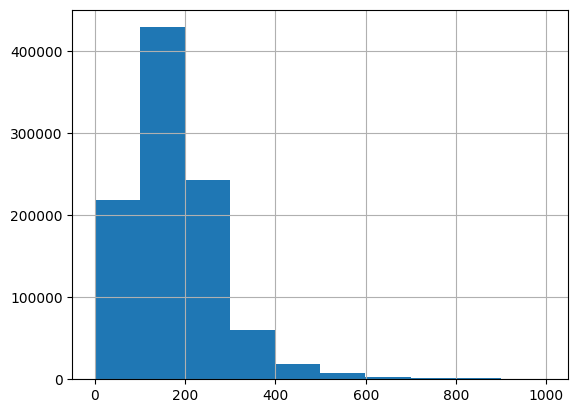

In [6]:
def word_count(s):
    return len(s.split()) if type(s) == str else np.NaN

abstract_wordcounts = articles_md.abstract.apply(word_count)
abstract_wordcounts[abstract_wordcounts < 1000].hist();

In [7]:
abstract_wordcounts.describe()

count    985874.000000
mean        179.398189
std         125.418332
min           0.000000
25%         106.000000
50%         159.000000
75%         229.000000
max        3714.000000
Name: abstract, dtype: float64

In [8]:
articles_md['abstract_word_count'] = abstract_wordcounts
print(articles_md.sort_values('abstract_word_count').abstract.dropna().iloc[-1])

Lorsque la Fédération des travailleurs de l'Ontario avait décidé d’étudier le problème de la crise constitutionnelle que traverse le Canada, elle avait souhaité entendre le point de vue, sinon du Québec, du moins d'un travailleur syndiqué du Québec.Far be it from me to minimize the initiative you have taken, but I cannot help telling you, without making the Ontario Federation of Labour a specific target, that Labour allowed itself to wait far too long. For, ever since the Quebec Federation of Labour, at the very outset of the work by the Laurendeau-Dunton Commission on Bilingualism and Biculturalism, asked this body to organize conferences between trade unionists throughout the country, we have continued to await such an invitation from an organisation such as yours. Following up on the efforts of the Montreal Labour Council, the QFL also called upon the Canadian Labour Congress to organize such a meeting.If we attach so much importance to such meetings of unionized workers outside of 

## Registration authority

In [9]:
doi_ra = pd.read_csv('../data/doi_ra.csv').drop_duplicates(subset='doi').dropna()
doi_ra = doi_ra[doi_ra.ra =='Crossref']
print(doi_ra.describe())

                            doi        ra
count                   1598295   1598295
unique                  1598295         1
top     10.1111/1467-8330.00227  Crossref
freq                          1   1598295


## Crossref data

### Inspecting the raw data

In [10]:
with gzip.open('../data/crossref_data_sample.json.gz') as f:
    cr_json0 = json.load(f)
cr_json0.keys()

dict_keys(['items'])

In [11]:
cr_list0 = cr_json0['items']
cr_list0[2].keys()

dict_keys(['abstract', 'URL', 'resource', 'member', 'score', 'created', 'license', 'ISSN', 'container-title', 'issued', 'issue', 'prefix', 'reference-count', 'indexed', 'author', 'DOI', 'is-referenced-by-count', 'published', 'published-print', 'alternative-id', 'subject', 'content-domain', 'reference', 'title', 'link', 'source', 'type', 'publisher', 'journal-issue', 'volume', 'references-count', 'issn-type', 'deposited', 'language', 'page'])

In [12]:
cr_list0[0]['subject']

['Physical and Theoretical Chemistry', 'General Physics and Astronomy']

In [13]:
cf_df0 = pd.DataFrame(
    [{
        'doi': item['DOI'],
        'subjects': item['subject'] if 'subject' in item.keys() else np.NaN,
        'journal_title': item['container-title'][0]
    } for item in cr_list0]
)
print(cf_df0.info())
cf_df0.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   doi            5000 non-null   object
 1   subjects       4742 non-null   object
 2   journal_title  5000 non-null   object
dtypes: object(3)
memory usage: 117.3+ KB
None


,doi,subjects,journal_title
0,10.1063/1.1486445,"[Physical and Theoretical Chemistry, General P...",The Journal of Chemical Physics
1,10.1021/cm011675j,"[Materials Chemistry, General Chemical Enginee...",Chemistry of Materials
2,10.1108/01443579610125787,"[Management of Technology and Innovation, Stra...",International Journal of Operations &amp; Prod...
3,10.1108/01437730110380183,[Organizational Behavior and Human Resource Ma...,Leadership &amp; Organization Development Journal
4,10.1149/1.1392654,"[Materials Chemistry, Electrochemistry, Surfac...",Journal of The Electrochemical Society


In [14]:
subjects_list = []
for l in cf_df0.subjects.dropna():
    subjects_list.extend(l)
subjects = pd.Series(subjects_list)
# print(subjects.value_counts().index)
print(np.unique(subjects_list))

['Accounting' 'Acoustics and Ultrasonics'
 'Advanced and Specialized Nursing' 'Aerospace Engineering' 'Aging'
 'Agricultural and Biological Sciences (miscellaneous)'
 'Agronomy and Crop Science' 'Algebra and Number Theory' 'Analysis'
 'Analytical Chemistry' 'Anesthesiology and Pain Medicine'
 'Animal Science and Zoology' 'Anthropology' 'Applied Mathematics'
 'Applied Microbiology and Biotechnology' 'Applied Psychology'
 'Aquatic Science' 'Architecture' 'Artificial Intelligence'
 'Arts and Humanities (miscellaneous)' 'Astronomy and Astrophysics'
 'Atomic and Molecular Physics, and Optics' 'Automotive Engineering'
 'Behavioral Neuroscience' 'Biochemistry' 'Bioengineering' 'Biomaterials'
 'Biomedical Engineering' 'Biophysics' 'Biotechnology'
 'Building and Construction' 'Business and International Management'
 'Business, Management and Accounting (miscellaneous)' 'Cancer Research'
 'Cardiology and Cardiovascular Medicine' 'Catalysis' 'Cell Biology'
 'Cellular and Molecular Neuroscience' '

In [15]:
cf_df0.dropna(subset='subjects')[cf_df0.subjects.dropna().apply(lambda l: 'Literature and Literary Theory' in l)]
# cf_df0[cf_df0.subjects.str.contains('liter', case=False, na=False)]

,doi,subjects,journal_title
1927,10.1080/147538202320147830,"[Literature and Literary Theory, Cultural Stud...",Bulletin of Spanish Studies
2557,10.1016/s0304-422x(02)00008-6,"[Literature and Literary Theory, Linguistics a...",Poetics
2626,10.1163/156853302760013866,"[Literature and Literary Theory, Linguistics a...",Vetus Testamentum
3077,10.1080/13696810220146100,"[Literature and Literary Theory, Linguistics a...",Journal of African Cultural Studies
3157,10.1163/156853302760013857,"[Literature and Literary Theory, Linguistics a...",Vetus Testamentum
4730,10.1080/09670880220148348,"[Literature and Literary Theory, Sociology and...",Irish Studies Review


### After filtering for matching DOIs

In [16]:
crossref_data = pd.read_csv('../data/cr_data.csv.gz')
print(crossref_data.info())
print(crossref_data.head())
with open('../data/all_subjects.txt', mode='r') as f:
    all_subjects = f.read().split('\n')
all_subjects[:5]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1594710 entries, 0 to 1594709
Data columns (total 6 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   DOI            1594710 non-null  object
 1   subjects       1594710 non-null  object
 2   journal_title  1574104 non-null  object
 3   title          1594290 non-null  object
 4   abstract       307092 non-null   object
 5   lang           1098525 non-null  object
dtypes: object(6)
memory usage: 73.0+ MB
None
                             DOI  \
0         10.1556/650.2018.31120   
1         10.1556/650.2018.31095   
2  10.1093/bioinformatics/bty500   
3        10.1556/0806.46.2018.02   
4           10.3390/ijms19061814   

                                            subjects  \
0                               ['General Medicine']   
1                               ['General Medicine']   
2  ['Computational Mathematics', 'Computational T...   
3  ['Genetics', 'Agronomy and Crop Scienc

['Biomaterials',
 'Microbiology',
 'Control and Systems Engineering',
 'Endocrinology, Diabetes and Metabolism',
 'Health (social science)']

In [17]:
jats_regex = r'(\</?jats.+?\>)'

matches_jats = crossref_data.abstract.str.extractall(jats_regex).value_counts()

In [18]:
matches_jats.to_csv('jats.txt')

In [19]:
crossref_data.abstract = crossref_data.abstract.str.replace(jats_regex, '', case=False, regex=True)
crossref_data.abstract.head()

0     Abstract:  Data from epidemiological and clin...
1     Abstract:  Introduction: The determination of...
2    Abstract\n               \n                  M...
3                                                  NaN
4                                                  NaN
Name: abstract, dtype: object

In [20]:
other_tags = r'(&lt;[\D]+?&gt;)'
crossref_data.abstract.str.extractall(other_tags).value_counts().to_csv('tags.txt')

In [21]:
crossref_data.abstract = crossref_data.abstract.str.replace(other_tags, '', regex=True)

In [22]:
remove_heading = r'(^\s*Abstract[.:\s\\n]*)'
matches_heading = crossref_data.abstract.str.extractall(remove_heading)

In [23]:
print(matches_heading.shape)
print(matches_heading.value_counts())

(63311, 1)
Abstract\n          \n                                                  20961
Abstract                                                                19630
Abstract.                                                                7516
Abstract\n                                                               6337
Abstract\n                                                               3707
                                                                        ...  
Abstract\n            \n                                                    1
Abstract\n               \n                  \n                             1
Abstract\n               \n                  n                              1
Abstract\n               :                                                  1
                      Abstract                                              1
Name: count, Length: 101, dtype: int64


In [24]:
crossref_data.abstract = crossref_data.abstract.str.replace(remove_heading, '', regex=True)

In [25]:
remove_heading_alt = r'(\S\s*Abstract)'
crossref_data.abstract.str.extractall(remove_heading_alt).to_csv('list.txt')

In [26]:
crossref_data.abstract[165305]

"PERGESERAN NILAI-NILAI BUDAYA MINANGKABAU DALAM NOVEL PERSIDEN KARYA WISRAN HADI (KAJIAN STRUKTURALISME GENETIK)AbstractThis study aims obtaining an understanding of the shifting of Minangkabau cultural values. It uses qualitative descriptive through genetic structuralism approach. Issues covered are: (1) description of the intrinsic elements; (2) shift in cultural values in terms of social structure; (3) shift in cultural values in terms of the author's view. Data are sentences or paragraphs, dialogue and monologue taken from the novel Persiden written by Wisran Hadi. The intrinsic elements are themes, plots, characters, and background. Shifting social structure includes the nature of man and fellow covering courtesy, consensus, reconciliation, and responsibility. The life nature involves religious culture. The work nature includes the independence and human nature against time includes discipline value. The author's view includes change or inclusion of something that will shift the 

In [27]:
def cr_subject_filter(s):
    if not type(s) == str:
        return False
    subject_phrases = [
        'social sciences',
        'literature',
        'history',
        'sociology',
        'cultural studies',
        'philosophy',
        'arts',
        'gender studies',
        'urban studies',
        'international relations'
    ]
    lowered = s.lower()
    for phrase in subject_phrases:
        if phrase in lowered:
            return True
    return False

In [28]:
# crossref_data.to_csv('../data/cr_filtered_subjects.csv', index=False)

## Joining CR and CORE Metadata

In [29]:
# crossref_data = pd.read_csv('../data/cr_filtered_subjects.csv')
crossref_data.rename(columns={'DOI':'doi'}, inplace=True)
crossref_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1594710 entries, 0 to 1594709
Data columns (total 6 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   doi            1594710 non-null  object
 1   subjects       1594710 non-null  object
 2   journal_title  1574104 non-null  object
 3   title          1594290 non-null  object
 4   abstract       307092 non-null   object
 5   lang           1098525 non-null  object
dtypes: object(6)
memory usage: 73.0+ MB


In [30]:
crossref_data['abstract_word_count'] = crossref_data.abstract.apply(word_count)

In [31]:
crossref_data.abstract_word_count.describe()

count    307092.000000
mean        175.762804
std          89.492676
min           0.000000
25%         119.000000
50%         168.000000
75%         220.000000
max        3169.000000
Name: abstract_word_count, dtype: float64

In [32]:
joined_df = articles_md.merge(crossref_data, on='doi', how='left', suffixes=('_core', '_crossref'))
joined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 986811 entries, 0 to 986810
Data columns (total 12 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   doi                           986811 non-null  object 
 1   title_core                    986807 non-null  object 
 2   abstract_core                 985874 non-null  object 
 3   issn                          915137 non-null  object 
 4   subjects_core                 30872 non-null   object 
 5   abstract_word_count_core      985874 non-null  float64
 6   subjects_crossref             954653 non-null  object 
 7   journal_title                 944093 non-null  object 
 8   title_crossref                954317 non-null  object 
 9   abstract_crossref             187423 non-null  object 
 10  lang                          585407 non-null  object 
 11  abstract_word_count_crossref  187423 non-null  float64
dtypes: float64(2), object(10)
memory usage: 90.3

In [33]:
subject_mask = (
    joined_df.subjects_crossref.apply(cr_subject_filter) | 
    ~joined_df.subjects_core.isna()
)
joined_df = joined_df[subject_mask]
print('*****\nAfter filtering for subjects:')
joined_df.info()

*****
After filtering for subjects:
<class 'pandas.core.frame.DataFrame'>
Index: 90129 entries, 1 to 986798
Data columns (total 12 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   doi                           90129 non-null  object 
 1   title_core                    90128 non-null  object 
 2   abstract_core                 89793 non-null  object 
 3   issn                          89001 non-null  object 
 4   subjects_core                 30872 non-null  object 
 5   abstract_word_count_core      89793 non-null  float64
 6   subjects_crossref             89671 non-null  object 
 7   journal_title                 89484 non-null  object 
 8   title_crossref                89652 non-null  object 
 9   abstract_crossref             28134 non-null  object 
 10  lang                          41124 non-null  object 
 11  abstract_word_count_crossref  28134 non-null  float64
dtypes: float64(2), object(10)
me

In [34]:
print('Language')
print(joined_df.lang.value_counts(dropna=False))

Language
lang
NaN    49005
en     39217
fr      1258
es       348
de       150
ru        54
pt        29
si        17
hu        11
sl        11
ng        10
nl         4
cs         4
it         4
pl         2
hr         2
la         2
tr         1
Name: count, dtype: int64


In [35]:
print(joined_df[~joined_df.abstract_crossref.isna()][['abstract_word_count_core', 'abstract_word_count_crossref']].describe())
joined_df[~joined_df.abstract_crossref.isna()][['abstract_core', 'abstract_crossref']].tail(10)

       abstract_word_count_core  abstract_word_count_crossref
count              28067.000000                  28134.000000
mean                 234.836926                    153.322279
std                  220.953856                     96.398131
min                    0.000000                      0.000000
25%                  127.000000                    102.000000
50%                  183.000000                    140.000000
75%                  269.000000                    185.000000
max                 3714.000000                   3169.000000


,abstract_core,abstract_crossref
985936,"Edição trilingue: português, espanhol e inglês...",O avanço dos direitos humanos requer que os tr...
985972,У статті на основі вивчення літератури та джер...,Balancing work with family life has become on...
985984,"À la fin de la période de la Nouvelle-France, ...","À la fin de la période de la Nouvelle-France, ..."
986180,"Ressenya a Juan Francisco Mesa Sanz (ed.), Lat...","Ressenya a Juan Francisco Mesa Sanz (ed.), Lat..."
986184,[[abstract]]Purpose – The purpose of this pape...,PurposeThe purpose of this paper is to investi...
986234,Resum: El Curial e Güelfa és una novel·la que ...,Resum: El Curial e Güelfa és una novel·la que ...
986270,"REssenya a Antoni Ferrando Francés, Aportacion...","REssenya a Antoni Ferrando Francés, Aportacion..."
986415,Resum: El present treball analitza comparativa...,Resum: El present treball analitza comparativa...
986416,"Resum: Curial e Güelfa (Milà-Nàpols, ca. 1445-...","Resum: Curial e Güelfa (Milà-Nàpols, ca. 1445-..."
986492,The authors present an introduction to the new...,The authors present an introduction to the ne...


In [36]:
joined_df[joined_df.lang.isna()].tail()

,doi,title_core,abstract_core,issn,subjects_core,abstract_word_count_core,subjects_crossref,journal_title,title_crossref,abstract_crossref,lang,abstract_word_count_crossref
986750,10.1515/bgsl.1892.1892.16.516,Zur Hildensage.,n/,'0005-8076',NaN,1.0,"['Literature and Literary Theory', 'Linguistic...",Beiträge zur Geschichte der deutschen Sprache ...,['ZUR HILDENSAGE.'],NaN,NaN,NaN
986754,10.1163/187501791x00425,Huybert tons Jansz,n/,'0030-672X',NaN,1.0,['Visual Arts and Performing Arts'],Oud Holland - Quarterly for Dutch Art History,['Huybert tons Jansz'],NaN,NaN,NaN
986784,10.1515/byzs.1897.6.2.285,Leon Diakonos und die Chronisten.,n/,'0007-7704',art,1.0,"['Literature and Literary Theory', 'Visual Art...",Byzantinische Zeitschrift,['Leon Diakonos und die Chronisten.'],NaN,NaN,NaN
986787,10.1163/187501793x00234,De Munten En De Waarde Van Het Geld in Het Beg...,n/,'0030-672X',NaN,1.0,['Visual Arts and Performing Arts'],Oud Holland - Quarterly for Dutch Art History,['De Munten En De Waarde Van Het Geld in Het B...,NaN,NaN,NaN
986798,10.5565/rev/studiaaurea.279,A Királyi Magyar Természettudományi Társulat é...,Pierre DarnisLa picaresca en su centro. Guzmán...,"'issn:1988-1088', '1988-1088'",NaN,45.0,"['Literature and Literary Theory', 'History']",Studia Aurea,['Pierre Darnis. La picaresca en su centro. Gu...,NaN,NaN,NaN


In [37]:
take_crossref_abstract = (
    # Crossref abstract present, and
    ~joined_df.abstract_crossref.isna() & (
        # Crossref abstract present, or
        joined_df.abstract_core.isna() | (
            # CORE abstract is not proper abstract while Crossref one is
            ((joined_df.abstract_word_count_core < 90) | (joined_df.abstract_word_count_core > 500)) &
            ((joined_df.abstract_word_count_crossref >= 100) & (joined_df.abstract_word_count_core <= 500))
        )
    )
)
joined_df.loc[take_crossref_abstract,['abstract_core', 'abstract_crossref']].head()

,abstract_core,abstract_crossref
306,is is the author's PDF version of an article p...,"Since 1990, there has been something of a reve..."
9439,This article has been accepted for publication...,This article explores how sovereignty and (non...
13198,Peer reviewedPublisher PD,Brexit presents English local authorities with...
35794,This is the author's pdf version of an article...,"The so-called 'happiness hypothesis', associat..."
41866,Définition de l'équipe basée sur celle d'Ervin...,"In this article, I suggest that the prevailin..."


In [38]:
joined_df = joined_df[joined_df.lang == 'en']

In [39]:
joined_df['abstract'] = joined_df.abstract_core.where(~joined_df.abstract_core.isna(), joined_df.abstract_crossref)
joined_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 39217 entries, 3 to 986790
Data columns (total 13 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   doi                           39217 non-null  object 
 1   title_core                    39216 non-null  object 
 2   abstract_core                 39212 non-null  object 
 3   issn                          38620 non-null  object 
 4   subjects_core                 11032 non-null  object 
 5   abstract_word_count_core      39212 non-null  float64
 6   subjects_crossref             39217 non-null  object 
 7   journal_title                 39172 non-null  object 
 8   title_crossref                39214 non-null  object 
 9   abstract_crossref             9766 non-null   object 
 10  lang                          39217 non-null  object 
 11  abstract_word_count_crossref  9766 non-null   float64
 12  abstract                      39212 non-null  object 
dtypes: fl

In [40]:
joined_df['subjects'] = joined_df.subjects_crossref.fillna(joined_df.subjects_core)

In [41]:
joined_df['title'] = joined_df.title_core.fillna(joined_df.title_crossref.str.slice(2,-2))
joined_df.title.isna().sum()

0

In [42]:
joined_df['abstract_word_count'] = joined_df.abstract.apply(word_count)

Dropping records that still have no abstract, as well as now-unneeded columns

In [43]:
columns_to_drop = list(filter(lambda s: s.endswith('_crossref') or s.endswith('_core'), joined_df.columns))
columns_to_drop.append('lang')
print(columns_to_drop)
joined_df.drop(columns=columns_to_drop, inplace=True)
joined_df.dropna(subset=['abstract'], inplace=True)
joined_df.info()

['title_core', 'abstract_core', 'subjects_core', 'abstract_word_count_core', 'subjects_crossref', 'title_crossref', 'abstract_crossref', 'abstract_word_count_crossref', 'lang']
<class 'pandas.core.frame.DataFrame'>
Index: 39212 entries, 3 to 986790
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   doi                  39212 non-null  object 
 1   issn                 38615 non-null  object 
 2   journal_title        39167 non-null  object 
 3   abstract             39212 non-null  object 
 4   subjects             39212 non-null  object 
 5   title                39212 non-null  object 
 6   abstract_word_count  39212 non-null  float64
dtypes: float64(1), object(6)
memory usage: 2.4+ MB


## Checking example of records from one particular journal.

In [44]:
joined_df[joined_df.issn.str.contains('0304-2421', na=False)].head(3).T

,227008,291240,408113
doi,10.1007/s11186-012-9172-x,10.1007/bf00159259,10.1007/s11186-015-9251-x
issn,"'issn:0304-2421', '0304-2421'",'0304-2421','0304-2421'
journal_title,Theory and Society,Theory and Society,Theory and Society
abstract,This is the author's accepted manuscript. The ...,"A discussion of Allen E. Buchanan, Marx and Ju...",Although contemporary theorists of revolution ...
subjects,"['Sociology and Political Science', 'History']","['Sociology and Political Science', 'History']","['Sociology and Political Science', 'History']"
title,"Discourse or dialogue? Habermas, the Bakhtin C...",Marx and morality: an impossible synthesis?,Revolutions and the international
abstract_word_count,232.0,59.0,147.0


## Restricting length and cleaning up abstracts
1. "Abstracts" shorter than around 100 words seem to usually be instead notes, and if not are so short that there is little in the way of summary.
1. On the longer side, for the sake of modeling efficiency, it makes sense to restrict to around 300 words, which is a common limit.
1. There are still some extraneous contents, such as notes like "this is the author's accepted manuscript. Using the keywords, 'manuscript', 'preprint', and 'postprint', there seem to be only several hundred cases, most of which do not have proper abstracts at all. It is easiest to drop them.
1. Excessive whitespace and line breaks are undesirable, and there seems to be a systematic problem of the closing period having been cut off.

In [45]:
print("Short example:\n", joined_df[joined_df.abstract_word_count<100].abstract.sample().iloc[0])
print("\nLong example:\n", joined_df[joined_df.abstract_word_count>300].abstract.sample().iloc[0])

Short example:
 Peer Reviewedhttp://deepblue.lib.umich.edu/bitstream/2027.42/73142/1/j.1939-0025.1988.tb01562.x.pd

Long example:
 BACKGROUND
Accountability for ensuring sexual and reproductive health and rights is increasingly receiving
global attention. Less attention has been paid to accountability mechanisms for sexual
and reproductive health and rights at national and sub-national level, the focus of this systematic
review.
METHODS
We searched for peer-reviewed literature using accountability, sexual and reproductive
health, human rights and accountability instrument search terms across three electronic
databases, covering public health, social sciences and legal studies. The search yielded
1906 articles, 40 of which met the inclusion and exclusion criteria (articles on low and middle-
income countries in English, Spanish, French and Portuguese published from 1994 and
October 2016) defined by a peer reviewed protocol.
RESULTS
Studies were analyzed thematically and through frequenc

In [46]:
joined_df = joined_df[joined_df.abstract_word_count.between(100,300)]
joined_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29573 entries, 3 to 986612
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   doi                  29573 non-null  object 
 1   issn                 29058 non-null  object 
 2   journal_title        29538 non-null  object 
 3   abstract             29573 non-null  object 
 4   subjects             29573 non-null  object 
 5   title                29573 non-null  object 
 6   abstract_word_count  29573 non-null  float64
dtypes: float64(1), object(6)
memory usage: 1.8+ MB


In [47]:
joined_df.abstract[joined_df.abstract.str.contains('manuscript')]

23008     This is the author's accepted manuscript. The ...
23020     This is the author's accepted manuscript. The ...
23446     University-community partnerships are increasi...
24231     This is the author's accepted manuscript. The ...
24237     This is the author's accepted manuscript. The ...
                                ...                        
981256    Among those witnesses of John Gower's works th...
985587    This essay argues that in the Commedia song be...
985774    This is the author accepted manuscript. The fi...
985992    Your article is protected by copyright and all...
986490    In the middle of the eighteenth century, Carl ...
Name: abstract, Length: 565, dtype: object

In [48]:
joined_df.abstract[joined_df.abstract.str.contains('postprint') | joined_df.abstract.str.contains('preprint')]

12020     In this paper, we study the dual representatio...
38463     This is a postprint (author's final draft) ver...
40933     This is a postprint (author's final draft) ver...
90860     This is the author's PDF preprint of an articl...
107269    This is the author's original (preprint) versi...
187988    Computer-mediated communication is driving fun...
282333    This is a preprint of an article whose final a...
293552    preprintA peer-reviewed lecture delivered at R...
296762    Note that this is the postprint version, not t...
335900    This is a postprint of an article published in...
338503    types: ArticleThis is a postprint of an articl...
350821    publication-status: Publishedtypes: ArticleThi...
354860    This is a postprint of an article published in...
379760    This is a preprint of an article published in ...
450357    This is a preprint of an article published in ...
467044    publication-status: Publishedtypes: ArticleThi...
480289    This is a postprint of an arti

In [49]:
non_abstracts = (lambda col:
    col.str.contains('manuscript') | 
    col.str.contains('preprint') | 
    col.str.contains('postprint')
)
joined_df = joined_df[~non_abstracts(joined_df.abstract)]
joined_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 28982 entries, 3 to 986612
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   doi                  28982 non-null  object 
 1   issn                 28467 non-null  object 
 2   journal_title        28947 non-null  object 
 3   abstract             28982 non-null  object 
 4   subjects             28982 non-null  object 
 5   title                28982 non-null  object 
 6   abstract_word_count  28982 non-null  float64
dtypes: float64(1), object(6)
memory usage: 1.8+ MB


In [50]:
def ending_period(s):
    return s if s.endswith('.') else s+'.'

joined_df.abstract.apply(ending_period).sample().iloc[0]

'The paper puts forward a discourse-semantic account of the notoriously evasive phenomena of contrastivity and emphasis. Based on new evidence from Chadic, it is argued that occurrences of focus that are treated in terms of ‘contrastive focus’, ‘kontrast’ (Vallduví-Vilkuna 1998) or ‘identificational focus’ (É. Kiss 1998) in the literature should not be analyzed in familiar semantic terms as involving the introduction and subsequent exclusion of alternatives. Rather, an adequate analysis must take into account discourse-semantic notions like ‘hearer expectation’ or ‘discourse expectability’ of the focused content in a given discourse situation. The less expected the focus content is judged to be for the hearer, relative to the Common Ground, the more likely a speaker is to mark the focus constituent by means of special grammatical devices, thus giving rise to emphasis.'

In [51]:
joined_df.abstract.str.extractall(other_tags)

0
       match              
22282  0         &lt;p&gt;
       1        &lt;/p&gt;
       2         &lt;p&gt;
42936  0         &lt;p&gt;
       1        &lt;/p&gt;
131688 0       &lt;sup&gt;
       1      &lt;/sup&gt;
       2       &lt;sup&gt;
       3      &lt;/sup&gt;
       4       &lt;sup&gt;
       5      &lt;/sup&gt;
       6       &lt;sup&gt;
       7      &lt;/sup&gt;
144723 0         &lt;p&gt;
       1        &lt;/p&gt;
       2         &lt;p&gt;
       3        &lt;/p&gt;
       4         &lt;p&gt;
173068 0         &lt;p&gt;
       1        &lt;/p&gt;
184325 0         &lt;p&gt;
       1        &lt;/p&gt;
       2         &lt;p&gt;
267234 0         &lt;i&gt;
       1        &lt;/i&gt;
       2         &lt;i&gt;
       3        &lt;/i&gt;
       4         &lt;i&gt;
       5        &lt;/i&gt;
623769 0       &lt;br/&gt;
       1       &lt;br/&gt;
657435 0         &lt;i&gt;
       1        &lt;/i&gt;
822471 0         &lt;p&gt;
       1        &lt;/p&gt;
       2         &lt;p&gt;
       3        &lt;/p&gt;
       4         &lt;p&gt;
       5        &lt;/p&gt;

In [52]:
joined_df.abstract.str.extractall(remove_heading)

,,0
,match,
106596,0,Abstract \n\n
107156,0,Abstract:
107262,0,Abstract\n
108125,0,Abstract
108593,0,Abstract\n
...,...,...
962476,0,Abstract:\n\n\n\n
970465,0,Abstract
973806,0,Abstract:


In [53]:
joined_df.abstract = (
    joined_df.abstract
        .str.replace(other_tags, '', regex=True)
        .str.replace(remove_heading, '', regex=True)
        .str.replace('\n', ' ')
        .apply(ending_period)
)

In [54]:
joined_df.to_csv('../data/cleaned_metadata.csv', index=False)

## Cleaning up memory

In [55]:
del articles_md, cf_df0, crossref_data, doi_ra

# Joining full text

Example 10k records

In [56]:
df400k = pd.read_csv('../data/400k_articles.csv.gz', nrows=10_000)
print(df400k.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   doi       10000 non-null  object
 1   title     10000 non-null  object
 2   fulltext  9995 non-null   object
 3   abstract  10000 non-null  object
 4   issn      9729 non-null   object
 5   subjects  2669 non-null   object
dtypes: object(6)
memory usage: 468.9+ KB
None


Reading the data from two files in chunks. Instead of taking all of the metadata from this records, we will just use the DOI to join the full text alone.

In [57]:
DOIs = joined_df.doi.sort_values()
fulltext_files = ['../data/400k_articles.csv.gz', '../data/750k_articles.csv.gz']
fulltext_dfs = []
for file in fulltext_files:
    data_reader = pd.read_csv(file, chunksize = 50_000, usecols=['doi', 'fulltext'])
    for df in data_reader:
        df = df[df.doi.isin(DOIs)]
        fulltext_dfs.append(df)
fulltext_with_duplicates = pd.concat(fulltext_dfs)
del fulltext_dfs

In [58]:
fulltext_with_duplicates.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17545 entries, 3 to 757641
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   doi       17545 non-null  object
 1   fulltext  17521 non-null  object
dtypes: object(2)
memory usage: 411.2+ KB


Removing fully duplicated entries

In [59]:
fulltext_doi = fulltext_with_duplicates.drop_duplicates().copy()
print(fulltext_doi.info())
print('Duplicate DOI, different full text:', fulltext_doi.duplicated(subset='doi').sum())

<class 'pandas.core.frame.DataFrame'>
Index: 14330 entries, 3 to 757641
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   doi       14330 non-null  object
 1   fulltext  14308 non-null  object
dtypes: object(2)
memory usage: 335.9+ KB
None
Duplicate DOI, different full text: 75


Entries with different full text but same DOI seem to reflect minor format differences between different repositories (e.g. for different co-authors' institutions).

In [60]:
fulltext_doi[fulltext_doi.duplicated(subset='doi', keep=False)].sort_values('doi').head()

,doi,fulltext
276398,10.1002/casp.2296,Open Research OnlineThe Open University’s repo...
423037,10.1002/casp.2296,Contact and collective action: An Indian case ...
343473,10.1007/s10551-017-3618-z,This is a repository copy of ‘Lower than a Sna...
410166,10.1007/s10551-017-3618-z,Durham Research Online\nDeposited in DRO:\n04 ...
406465,10.1007/s10901-017-9553-6,This is a repository copy of Experiencing visu...


In [61]:
fulltext_doi.drop_duplicates(subset=['doi'], inplace=True)
fulltext_doi.dropna(inplace=True)

Adding a wordcount column

In [62]:
fulltext_doi['fulltext_word_count'] = fulltext_doi.fulltext.apply(word_count)
fulltext_doi.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14233 entries, 3 to 757641
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   doi                  14233 non-null  object
 1   fulltext             14233 non-null  object
 2   fulltext_word_count  14233 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 444.8+ KB


Joining the full text with the metadata

In [63]:
fulltext_joined = joined_df.merge(fulltext_doi, on='doi')
fulltext_joined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14233 entries, 0 to 14232
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   doi                  14233 non-null  object 
 1   issn                 14104 non-null  object 
 2   journal_title        14207 non-null  object 
 3   abstract             14233 non-null  object 
 4   subjects             14233 non-null  object 
 5   title                14233 non-null  object 
 6   abstract_word_count  14233 non-null  float64
 7   fulltext             14233 non-null  object 
 8   fulltext_word_count  14233 non-null  int64  
dtypes: float64(1), int64(1), object(7)
memory usage: 1000.9+ KB


In [64]:
fulltext_joined.head()

,doi,issn,journal_title,abstract,subjects,title,abstract_word_count,fulltext,fulltext_word_count
0,10.1177/1350508408095817,'1350-5084',Organization,Building on the work of Pierre Bourdieu and Ma...,"['Management of Technology and Innovation', 'S...",The Body Dances: Carnival Dance and Organization,176.0,The Body Dances: Carnival Dance \nand Organi...,7972
1,10.1177/1474022212467605,'1474-0222',Arts and Humanities in Higher Education,This research study explores the assessment pr...,"['Visual Arts and Performing Arts', 'Education']",Making judgements about students making work :...,156.0,Making judgements about students making work. ...,8621
2,10.1179/095936810x12790101593074,'0959-3683',Publications of the English Goethe Society,Late eighteenth-century consolatory texts for ...,['Literature and Literary Theory'],The sentimental novel as Trostschrift: Johann ...,135.0,\n \n \nBIROn - Birkbeck Institutional Resear...,6168
3,10.2304/csee.2011.10.1.46,'2047-1734',"Citizenship, Social and Economics Education",The role of perceived self-efficacy is importa...,"['General Economics, Econometrics and Finance'...",The role of perceived self-efficacy in the dev...,127.0,"\n \n \n \n \n \n \nJaap, A. and Patrick, F. ...",61
4,10.1016/j.chb.2007.07.013,"'0747-5632', 'issn:0747-5632'",Computers in Human Behavior,This is the post-print version of the Article....,"['General Psychology', 'Human-Computer Interac...",Measuring quality of perception in distributed...,151.0,Measuring Quality of Perception in Distributed...,5130


Some of the texts are either very short or very long. The former are not regular articles, and the other a too long to process.

In [69]:
print(fulltext_joined.fulltext_word_count.describe())
print("< 5,000:" ,np.sum(fulltext_joined.fulltext_word_count < 5000))
print("> 15,000:" ,np.sum(fulltext_joined.fulltext_word_count > 15000))

count     14233.000000
mean       8962.528279
std        4043.414058
min           0.000000
25%        6816.000000
50%        8733.000000
75%       10739.000000
max      115529.000000
Name: fulltext_word_count, dtype: float64
< 5,000: 1687
> 15,000: 703


In [70]:
fulltext_joined = fulltext_joined[fulltext_joined.fulltext_word_count.between(5000, 15000)]

In [71]:
def contains_abstract_whole(row):
    return row['abstract'] in row['fulltext']
def contains_abstract_part(row):
    length = len(row['abstract'])
    one_tenth = length // 10
    start = length // 2 - one_tenth
    end = start + 2*one_tenth
    selection = row['abstract'][start:end]
    return selection in row['fulltext']

print('full abstract matches: ', fulltext_joined.apply(contains_abstract_whole, axis=1).sum())
print('middle 20% abstract matches: ', fulltext_joined.apply(contains_abstract_part, axis=1).sum())
print('word \'Abstract\' appears: ', fulltext_joined.fulltext.str.contains(r'(?:Abstract)|(?:ABSTRACT)[.:\n]', regex=True).sum())

full abstract matches:  1241
middle 20% abstract matches:  2615
word 'Abstract' appears:  7169


In [72]:
((fulltext_joined.apply(contains_abstract_part, axis=1) & ~fulltext_joined.fulltext.str.contains('Abstract[:\\n]', regex=True)) | (~fulltext_joined.apply(contains_abstract_part, axis=1) & fulltext_joined.fulltext.str.contains(r'(?:Abstract)|(?:ABSTRACT)[.:\n]', regex=True))).sum()

7477

In [74]:
fulltext_joined[~(fulltext_joined.apply(contains_abstract_whole, axis=1) | fulltext_joined.apply(contains_abstract_part, axis=1))| fulltext_joined.fulltext.str.contains(r'(?:Abstract)|(?:ABSTRACT)[.:\n]', regex=True)]

,doi,issn,journal_title,abstract,subjects,title,abstract_word_count,fulltext,fulltext_word_count
0,10.1177/1350508408095817,'1350-5084',Organization,Building on the work of Pierre Bourdieu and Ma...,"['Management of Technology and Innovation', 'S...",The Body Dances: Carnival Dance and Organization,176.0,The Body Dances: Carnival Dance \nand Organi...,7972
1,10.1177/1474022212467605,'1474-0222',Arts and Humanities in Higher Education,This research study explores the assessment pr...,"['Visual Arts and Performing Arts', 'Education']",Making judgements about students making work :...,156.0,Making judgements about students making work. ...,8621
2,10.1179/095936810x12790101593074,'0959-3683',Publications of the English Goethe Society,Late eighteenth-century consolatory texts for ...,['Literature and Literary Theory'],The sentimental novel as Trostschrift: Johann ...,135.0,\n \n \nBIROn - Birkbeck Institutional Resear...,6168
4,10.1016/j.chb.2007.07.013,"'0747-5632', 'issn:0747-5632'",Computers in Human Behavior,This is the post-print version of the Article....,"['General Psychology', 'Human-Computer Interac...",Measuring quality of perception in distributed...,151.0,Measuring Quality of Perception in Distributed...,5130
5,10.1016/j.chb.2007.07.012,"'0747-5632', 'issn:0747-5632'",Computers in Human Behavior,This is the post-print version of the Article....,"['General Psychology', 'Human-Computer Interac...",Mobile information access in the real world: A...,258.0,1 \nMobile Information Access in the Real Wor...,8421
...,...,...,...,...,...,...,...,...,...
14227,10.1017/pls.2017.25,"'issn:0730-9384', '0730-9384'",Politics and the Life Sciences,Neuropolitics is the intersection of neuroscie...,"['Public Administration', 'Social Sciences (mi...",Neuropolitics: Twenty years later,140.0,RUNNING HEAD: Neuropolitics: Twenty years late...,12410
14229,10.1017/s0020859012000405,'0020-8590',International Review of Social History,This article argues that during the formative ...,"['Social Sciences (miscellaneous)', 'History']","The ""Bargain"" of Collaboration: African Interm...",135.0,"IRSH 57 (2012), Special Issue, pp. 17–38 doi:1...",9293
14230,10.1016/j.socscimed.2004.06.036,'0277-9536',Social Science &amp; Medicine,A majority of the world’s population will live...,"['History and Philosophy of Science', 'Health ...",Cities and population health,176.0,UCSF\nUC San Francisco Previously Published Wo...,13735
14231,10.1016/s0016-7185(00)00022-1,"'0016-7185', 'issn:0016-7185'",Geoforum,Copyright © 2000 Elsevier. NOTICE: This is the...,['Sociology and Political Science'],Narrating the Natural History Unit: institutio...,243.0,1Narrating the Natural History Unit: Instituti...,10475


These tests clearly don't catch instances where there are minor difference like whitespace.

In [75]:
print(fulltext_joined.loc[0, 'abstract'])
print(fulltext_joined.loc[0, 'fulltext'])

Building on the work of Pierre Bourdieu and Maurice Merleau-Ponty we seek to open up traditional categories of thought surrounding the relation `body-organization' and elicit a thought experiment: What happens if we move the body from the periphery to the centre? We pass the interlocking theoretical concepts of object-body/subject-body and habitus through the theoretically constructed empirical case of `carnival dance' in order to re-evaluate such key organizational concepts as knowledge and learning. In doing so, we connect with an emerging body of literature on `sensible knowledge'; knowledge that is produced and preserved within bodily practices. The investigation of habitual appropriation in carnival dance also allows us to make links between repetition and experimentation, and reflect on the mechanism through which the principles of social organization, whilst internalized and experienced as natural, are embodied so that humans are capable of spontaneously generating an infinite a

In [ ]:
fulltext_joined.to_csv('../data/fulltext_uncleaned.csv', index=False)